In [1]:
import sys
import numpy as np
import gym
import ray
from ray.rllib.agents import ppo, a3c, cql, ddpg, dqn

gym.logger.set_level(40)

sys.path.append("..")

from source.envs.env import WhitedBasicModel
from source.solvers.ray_solver import RaySolver

%load_ext autoreload

A3C_Trainer = a3c.A3CTrainer
PPO_Trainer = ppo.PPOTrainer
DQNTrainer = dqn.DQNTrainer

In [7]:
ray.shutdown()
ray.init()
env = WhitedBasicModel(env_config={"structural_params": {"gamma": [0.9,0.96],
                                                         "delta": [0.1, 0.3],
                                                         "theta": [0.5, 0.8],
                                                         "rho": [0.3, 0.8],
                                                         "sigma": [0., 0.15],
                                                        }, 
                                   "env_params": {"psi_func": lambda i, k: 0.01*i**2/(2*k)
                                                 },
                                   "is_mutable": True,
                                  })
solver = RaySolver(env=env,
                   trainer=A3C_Trainer,
                   solver_params={"verbose": True, "episodes": 30,
                                  "trainer_config": {
                                      "num_workers": 8,
                                      "gamma": env.current_structural_params.get("gamma", 0.99),
                                  }
                                  })
solver.train()
ray.shutdown()

2022-01-04 15:11:15,240	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-04 15:11:17,755	WARNING util.py:57 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=47965) 2022-01-04 15:11:17,730	WARNING deprecation.py:46 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!


agent_timesteps_total: 0
custom_metrics: {}
date: 2022-01-04_15-11-17
done: false
episode_len_mean: .nan
episode_media: {}
episode_reward_max: .nan
episode_reward_mean: .nan
episode_reward_min: .nan
episodes_this_iter: 0
episodes_total: 0
experiment_id: 1909ff1c71264a9da8d6ca287c78d6b3
hostname: mw-14.local
info:
  learner:
    default_policy:
      batch_count: 10
      learner_stats:
        allreduce_latency: 0.0
        cur_lr: 0.0001
        entropy_coeff: 0.01
        grad_gnorm: 274.0985107421875
        policy_entropy: 29.957210540771484
        policy_loss: 166.61790466308594
        vf_loss: 192.6852264404297
  num_steps_sampled: 10
  num_steps_trained: 10
iterations_since_restore: 1
node_ip: 127.0.0.1
num_healthy_workers: 8
off_policy_estimator: {}
perf:
  cpu_util_percent: 92.8
  ram_util_percent: 89.9
pid: 47825
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf: {}
time_since_restore: 0.11686396598815918
time_this_iter_s: 0.11686396598815918
t

In [15]:
solver.trainer.save()

'/Users/mingweima/ray_results/A3C_my-env_2022-01-04_15-11-160hhhuamk/checkpoint_000030/checkpoint-30'

In [8]:
# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = solver.act(obs)
    obs, reward, done, info = env.step(action, resample_param=False)
    episode_reward += reward
    print(obs, action, reward, done, info)

[1.25749457 0.9700405  0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.4722991689750693 False {}
[1.58129263 0.90323907 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.45165213447021 False {}
[1.98846686 0.93294728 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.35941292909829026 False {}
[2.50048637 0.86645037 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.3683846258613306 False {}
[3.14434814 0.90679449 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.19421556033282084 False {}
[3.95400071 0.92042851 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.1620510988062469 False {}
[4.97213459 0.92637265 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 0.038890249128181065 False {}
[6.25243235 1.05888259 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 -0.1644733279227797 False {}
[7.86239958 1.00871837 0.9427547  0.26882122 0.60876427 0.6685332
 0.06871083] 10 -0.0675428650036416 False {}
[9.886

In [11]:
"""Test trained agent for a single episode. Return the episode reward"""
cp = []
for eps in range(50):
      # instantiate env class
      episode_reward = 0
      done = False
      obs = env.reset()
      # run until episode ends
      caps = []
      while not done:
          action = solver.trainer.compute_single_action(obs, clip_action=True)
          obs, reward, done, info = env.step(action, resample_param=False)
          episode_reward += reward
          #print(action, obs, reward, done)
          caps += [obs[0]]
      cp += [ [caps] ]
cp = np.squeeze(np.array(cp)).mean(axis=0)

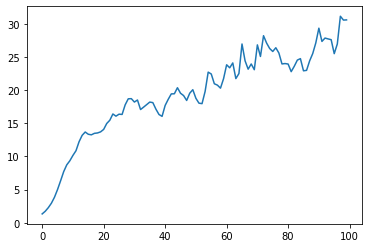

In [12]:
import matplotlib.pyplot as plt
plt.plot(cp)
plt.show()